In [2]:
% matplotlib inline
import os
import cv2
import json
import torch
import torchvision
from torch import nn
import pandas as pd
import numpy as np
from skimage import color, io
import matplotlib.pyplot as plt

from torchvision import transforms, models
from torchvision.datasets import MNIST
from torchsummary import summary

from sklearn.model_selection import KFold, train_test_split

from sklearn.datasets import make_regression
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split, SubsetRandomSampler

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [4]:
##############################################################
# CLASS FOR DATA HANDLING IN PYTORCH
##############################################################

class HumanoidData(Dataset):
    def __init__(self, image_tensor, annotations_tensor, train=True, transform=None):
        #Leaving only image related columns
        self.x = image_tensor.float()
        self.y = annotations_tensor.float()
        self.device = torch.device('cuda')

        #############################
        # TRANSFORMS
        #############################

        #Applying transformation
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        image = self.x[idx]
        labels = self.y[idx]

        return (image, labels)

In [6]:
print(torch.__version__)

# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

1.13.1


In [7]:
##############################################################
# LOAD TENSORS FROM FILES
##############################################################

device = torch.device('cpu')

humans_annotations_tensor = torch.load(
    '/Users/daniilbarkov/MyProjects/Uni/Pattern2/dataset/tensors/humans_annotation_tensor.pt', map_location=device)
humans_plain_image_tensor = torch.load(
    '/Users/daniilbarkov/MyProjects/Uni/Pattern2/dataset/tensors/humans_plain_image_tensor.pt', map_location=device)
humans_one_image_tensor = torch.load(
    '/Users/daniilbarkov/MyProjects/Uni/Pattern2/dataset/tensors/humans_one_image_tensor.pt', map_location=device)
humans_jeans_image_tensor = torch.load(
    '/Users/daniilbarkov/MyProjects/Uni/Pattern2/dataset/tensors/humans_jeans_image_tensor.pt', map_location=device)

##############################################################
# CREATE DATA OBJECTS AND PREPARE THEM FOR THE CNN WITH
# THE DATA LOADER CLASS
##############################################################

humans_plain_dataset = HumanoidData(humans_plain_image_tensor, humans_annotations_tensor)
humans_one_dataset = HumanoidData(humans_one_image_tensor, humans_annotations_tensor)
humans_jeans_dataset = HumanoidData(humans_jeans_image_tensor, humans_annotations_tensor)

# input_dataset goes into the neural net for train/val
# input_dataset = humans_one_dataset

##############################################################
# OUTPUT
##############################################################

# should be 14.000 images each -> 2000 monsters (500 x 2 poses x 2 genders)
# -> 12.000 humans (3000 x 2 poses x 2 genders)
print("Dataset/s loaded:")
print("----------------------------------------------------")
print("annotations_tensor:\t" + str(humans_annotations_tensor.size()))
print("plain_image_tensor:\t" + str(humans_plain_image_tensor.size()))
print("one_tensor:\t\t" + str(humans_one_image_tensor.size()))
print("jeans_tensor:\t\t" + str((humans_jeans_image_tensor.size())))
print("----------------------------------------------------")

Dataset/s loaded:
----------------------------------------------------
annotations_tensor:	torch.Size([12000, 8])
plain_image_tensor:	torch.Size([12000, 200, 200])
one_tensor:		torch.Size([12000, 200, 200])
jeans_tensor:		torch.Size([12000, 200, 200])
----------------------------------------------------


In [9]:
# input_dataset goes into the neural net for train/val
input_dataset = humans_one_dataset
# input_dataset = humans_plain_dataset
# input_dataset = humans_jeans_dataset

In [10]:
##############################################################
# CONVOLUTIONAL NEURAL NETWORK
##############################################################

class ConvNet(nn.Module):
    '''
    Simple Convolutional Neural Network
    '''

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(

            # input layer 200 x 200 x 1 - (in: 1 color channel, out: 8 Channels, ...)
            # output 196 x 196 x 8
            nn.Conv2d(1, 8, kernel_size=5),
            nn.ReLU(),

            # batch normalization layer
            nn.LayerNorm((196, 196)),

            # input 196 x 196 x 8
            # output 98 x 98 x 8
            nn.MaxPool2d(stride=2, kernel_size=1),

            # input 98 x 98 x 8
            # output 94 x 94 x 16
            nn.Conv2d(8, 16, kernel_size=5),
            nn.ReLU(),

            # input 94 x 94 x 16
            # output 47 x 47 x 16
            nn.MaxPool2d(stride=2, kernel_size=1),

            # Pooling Layer: Max pooling with stride 2. And then flatten.
            # Output: tensor of size 35344 = 47 x 47 x 16
            nn.Flatten(),
            nn.Linear(35344, 512),
            nn.ReLU(),

            # Last Layer - Regressor
            # input 35344
            # output 8
            nn.Linear(512, 8)

        )

    def forward(self, x):
        inputs = x.unsqueeze(1)
        outputs = self.layers(inputs)
        return outputs

In [11]:
##############################################################
# TRAIN LOOP
##############################################################

def train_epoch(model, dataloader, loss_fn, optimizer):
    train_loss, train_correct = 0.0, 0
    model.train()
    for images, labels in dataloader:
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    return train_loss

In [12]:
##############################################################
# TEST LOOP
##############################################################

def test_epoch(model, dataloader, loss_fn):
    test_loss = 0.0
    model.eval()
    diff, diff_fracture, diff_chest_circumference, diff_fracture_chest_circumference, diff_height, \
        diff_fracture_height, diff_inseam, diff_fracture_inseam, diff_left_arm_length, diff_fracture_left_arm_length, \
        diff_pelvis_circumference, diff_fracture_pelvis_circumference, diff_right_arm_length, diff_fracture_right_arm_length, \
        diff_shoulder_width, diff_fracture_shoulder_width, diff_waist_circumference, diff_fracture_waist_circumference = \
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    for images, labels in dataloader:
        output = model(images)
        loss = loss_fn(output, labels)
        test_loss += loss.item() * images.size(0)

        ##################
        # MAD METRICS
        ##################

        # (['chest_circumference', 'height', 'inseam', 'left_arm_length',
        # 'pelvis_circumference', 'right_arm_length', 'shoulder_width',
        # 'waist_circumference'],

        # AMAD
        diff += (abs(output - labels)).type(torch.float).sum().item()
        diff_fracture += (abs((output - labels) / labels)).type(torch.float).sum().item()

        diff_chest_circumference += (abs(output[:, 0] - labels[:, 0])).type(torch.float).sum().item()
        diff_fracture_chest_circumference += (abs((output[:, 0] - labels[:, 0]) / labels[:, 0])).type(
            torch.float).sum().item()

        diff_height += (abs(output[:, 1] - labels[:, 1])).type(torch.float).sum().item()
        diff_fracture_height += (abs((output[:, 1] - labels[:, 1]) / labels[:, 1])).type(torch.float).sum().item()

        diff_inseam += (abs(output[:, 2] - labels[:, 2])).type(torch.float).sum().item()
        diff_fracture_inseam += (abs((output[:, 2] - labels[:, 2]) / labels[:, 2])).type(torch.float).sum().item()

        diff_left_arm_length += (abs(output[:, 3] - labels[:, 3])).type(torch.float).sum().item()
        diff_fracture_left_arm_length += (abs((output[:, 3] - labels[:, 3]) / labels[:, 3])).type(
            torch.float).sum().item()

        diff_pelvis_circumference += (abs(output[:, 4] - labels[:, 4])).type(torch.float).sum().item()
        diff_fracture_pelvis_circumference += (abs((output[:, 4] - labels[:, 4]) / labels[:, 4])).type(
            torch.float).sum().item()

        diff_right_arm_length += (abs(output[:, 5] - labels[:, 5])).type(torch.float).sum().item()
        diff_fracture_right_arm_length += (abs((output[:, 5] - labels[:, 5]) / labels[:, 5])).type(
            torch.float).sum().item()

        diff_shoulder_width += (abs(output[:, 6] - labels[:, 6])).type(torch.float).sum().item()
        diff_fracture_shoulder_width += (abs((output[:, 6] - labels[:, 6]) / labels[:, 6])).type(
            torch.float).sum().item()

        diff_waist_circumference += (abs(output[:, 7] - labels[:, 7])).type(torch.float).sum().item()
        diff_fracture_waist_circumference += (abs((output[:, 7] - labels[:, 7]) / labels[:, 7])).type(
            torch.float).sum().item()

    return test_loss, diff, diff_fracture, diff_chest_circumference, diff_fracture_chest_circumference, diff_height, \
        diff_fracture_height, diff_inseam, diff_fracture_inseam, diff_left_arm_length, diff_fracture_left_arm_length, \
        diff_pelvis_circumference, diff_fracture_pelvis_circumference, diff_right_arm_length, diff_fracture_right_arm_length, \
        diff_shoulder_width, diff_fracture_shoulder_width, diff_waist_circumference, diff_fracture_waist_circumference

In [13]:
##############################################################
# HYPER PARAMETERS
##############################################################

# Loss Function
loss_fn = nn.MSELoss()

# Model of our Neural Network - push to GPU
model = ConvNet().to(device)

# Use Stochastic Gradient Descent as function to optimize
learning_rate = 0.01
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

summary(model, (200, 200), 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [1, 8, 196, 196]             208
              ReLU-2           [1, 8, 196, 196]               0
         LayerNorm-3           [1, 8, 196, 196]          76,832
         MaxPool2d-4             [1, 8, 98, 98]               0
            Conv2d-5            [1, 16, 94, 94]           3,216
              ReLU-6            [1, 16, 94, 94]               0
         MaxPool2d-7            [1, 16, 47, 47]               0
           Flatten-8                 [1, 35344]               0
            Linear-9                   [1, 512]      18,096,640
             ReLU-10                   [1, 512]               0
           Linear-11                     [1, 8]           4,104
Total params: 18,181,000
Trainable params: 18,181,000
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.15
Fo

In [33]:
##############################################################
# TRAIN NETWORK 
##############################################################

# Store AVG Loss for plotting
avg_losses = []
foldperf = {}

# Train Parameters
epochs = 20
folds_k = 5  # no_folds
batch_size = 100

# k-fold cross validation - 4 folds test, 1 fold test -> random state for replicable results
splits = KFold(n_splits=folds_k, shuffle=True, random_state=42)
print(len(input_dataset))

# k-fold cross validation - 4 folds test, 1 fold train
for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(input_dataset)))):

    print("-----------------------------------")
    print('Fold {}'.format(fold + 1))
    print("-----------------------------------")

    # get samples from k fold
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(input_dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(input_dataset, batch_size=batch_size, sampler=test_sampler)

    history = {'train_loss': [], 'test_loss': [], 'mad': [], 'rpe': [],
               'mad_chest_circumference': [], 'rpe_chest_circumference': [], 'mad_height': [], 'rpe_height': [],
               'mad_inseam': [], 'rpe_inseam': [], 'mad_left_arm_length': [], 'rpe_left_arm_length': [],
               'mad_pelvis_circumference': [], 'rpe_pelvis_circumference': [], 'mad_right_arm_length': [],
               'rpe_right_arm_length': [],
               'mad_shoulder_width': [], 'rpe_shoulder_width': [], 'mad_waist_circumference': [],
               'rpe_waist_circumference': []
               }

    # train epochs
    for epoch in range(epochs):
        ## 1 epoch of training with metrics
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer)

        # 1 epoch of testing with metrics
        test_loss, diff, diff_fracture, diff_chest_circumference, diff_fracture_chest_circumference, diff_height, \
            diff_fracture_height, diff_inseam, diff_fracture_inseam, diff_left_arm_length, diff_fracture_left_arm_length, \
            diff_pelvis_circumference, diff_fracture_pelvis_circumference, diff_right_arm_length, diff_fracture_right_arm_length, \
            diff_shoulder_width, diff_fracture_shoulder_width, diff_waist_circumference, diff_fracture_waist_circumference = test_epoch(
            model, test_loader, loss_fn)

        # Testing Metrics - I
        train_loss = train_loss / len(train_loader.sampler)
        test_loss = test_loss / len(test_loader.sampler)

        # Testing Metrics - II
        mad = diff / len(test_loader.sampler) * 1000
        rpe = diff_fracture / len(test_loader.sampler) * 100
        mad_chest_circumference = diff_chest_circumference / len(test_loader.sampler) * 1000
        rpe_chest_circumference = diff_fracture_chest_circumference / len(test_loader.sampler) * 100
        mad_height = diff_height / len(test_loader.sampler) * 1000
        rpe_height = diff_fracture_height / len(test_loader.sampler) * 100
        mad_inseam = diff_inseam / len(test_loader.sampler) * 1000
        rpe_inseam = diff_fracture_inseam / len(test_loader.sampler) * 100
        mad_left_arm_length = diff_left_arm_length / len(test_loader.sampler) * 1000
        rpe_left_arm_length = diff_fracture_left_arm_length / len(test_loader.sampler) * 100
        mad_pelvis_circumference = diff_pelvis_circumference / len(test_loader.sampler) * 1000
        rpe_pelvis_circumference = diff_fracture_pelvis_circumference / len(test_loader.sampler) * 100
        mad_right_arm_length = diff_right_arm_length / len(test_loader.sampler) * 1000
        rpe_right_arm_length = diff_fracture_right_arm_length / len(test_loader.sampler) * 100
        mad_shoulder_width = diff_shoulder_width / len(test_loader.sampler) * 1000
        rpe_shoulder_width = diff_fracture_shoulder_width / len(test_loader.sampler) * 100
        mad_waist_circumference = diff_waist_circumference / len(test_loader.sampler) * 1000
        rpe_waist_circumference = diff_fracture_waist_circumference / len(test_loader.sampler) * 100

        # Testing Metrics - III - Output
        print("Epoch:{}/{}\t Avg. Training Loss:{:.5f}\tAvg. Test Loss:{:.5f}".format(epoch + 1, epochs, train_loss,
                                                                                      test_loss))

        # Testing Metrics - IV - Storage for later analysis
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['mad'].append(mad)
        history['rpe'].append(rpe)
        history['mad_chest_circumference'].append(mad_chest_circumference)
        history['rpe_chest_circumference'].append(rpe_chest_circumference)
        history['mad_height'].append(mad_height)
        history['rpe_height'].append(rpe_height)
        history['mad_inseam'].append(mad_inseam)
        history['rpe_inseam'].append(rpe_inseam)
        history['mad_left_arm_length'].append(mad_left_arm_length)
        history['rpe_left_arm_length'].append(rpe_left_arm_length)
        history['mad_pelvis_circumference'].append(mad_pelvis_circumference)
        history['rpe_pelvis_circumference'].append(rpe_pelvis_circumference)
        history['mad_right_arm_length'].append(mad_right_arm_length)
        history['rpe_right_arm_length'].append(rpe_right_arm_length)
        history['mad_shoulder_width'].append(mad_shoulder_width)
        history['rpe_shoulder_width'].append(rpe_shoulder_width)
        history['mad_waist_circumference'].append(mad_waist_circumference)
        history['rpe_waist_circumference'].append(rpe_waist_circumference)

    # Testing Metrics - V - Storage for later analysis
    foldperf['fold{}'.format(fold)] = history

# Save our model with trained weights
torch.save(model, '/Users/daniilbarkov/MyProjects/Uni/Pattern2/dataset/tensors/k_cross_CNN.pt')

print("Done!")

12000
Done!


In [34]:
##############################################################
# EVALUATE NETWORK 
##############################################################

testl_f, tl_f, amad, arpe, mad_chest_circumference, rpe_chest_circumference, mad_height, rpe_height, mad_inseam, rpe_inseam, \
    mad_left_arm_length, rpe_left_arm_length, mad_pelvis_circumference, rpe_pelvis_circumference, mad_right_arm_length, rpe_right_arm_length, \
    mad_shoulder_width, rpe_shoulder_width, mad_waist_circumference, rpe_waist_circumference = [], [], [], [], [], [], [], [], [], [], \
    [], [], [], [], [], [], [], [], [], []

##############################################################
# CALCULATE METRICS OVER FOLDS
##############################################################
for f in range(folds_k):
    tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
    testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

    amad.append(np.mean(foldperf['fold{}'.format(f)]['mad']))
    arpe.append(np.mean(foldperf['fold{}'.format(f)]['rpe']))

    mad_chest_circumference.append(np.mean(foldperf['fold{}'.format(f)]['mad_chest_circumference']))
    rpe_chest_circumference.append(np.mean(foldperf['fold{}'.format(f)]['rpe_chest_circumference']))

    mad_height.append(np.mean(foldperf['fold{}'.format(f)]['mad_height']))
    rpe_height.append(np.mean(foldperf['fold{}'.format(f)]['rpe_height']))

    mad_inseam.append(np.mean(foldperf['fold{}'.format(f)]['mad_inseam']))
    rpe_inseam.append(np.mean(foldperf['fold{}'.format(f)]['rpe_inseam']))

    mad_left_arm_length.append(np.mean(foldperf['fold{}'.format(f)]['mad_left_arm_length']))
    rpe_left_arm_length.append(np.mean(foldperf['fold{}'.format(f)]['rpe_left_arm_length']))

    mad_pelvis_circumference.append(np.mean(foldperf['fold{}'.format(f)]['mad_pelvis_circumference']))
    rpe_pelvis_circumference.append(np.mean(foldperf['fold{}'.format(f)]['rpe_pelvis_circumference']))

    mad_right_arm_length.append(np.mean(foldperf['fold{}'.format(f)]['mad_right_arm_length']))
    rpe_right_arm_length.append(np.mean(foldperf['fold{}'.format(f)]['rpe_right_arm_length']))

    mad_shoulder_width.append(np.mean(foldperf['fold{}'.format(f)]['mad_shoulder_width']))
    rpe_shoulder_width.append(np.mean(foldperf['fold{}'.format(f)]['rpe_shoulder_width']))

    mad_waist_circumference.append(np.mean(foldperf['fold{}'.format(f)]['mad_waist_circumference']))
    rpe_waist_circumference.append(np.mean(foldperf['fold{}'.format(f)]['rpe_waist_circumference']))

##############################################################
# PRINT METRICS
##############################################################
print('Performance of {} fold cross validation'.format(folds_k))
print("""Average Training Loss: {:.5f} \t\t Average Test Loss: {:.5f}
AMAD: {:.5f} \t\t\t\t ARPE: {:.5f}
MAD_chest_circumference:  {:.5f} \t RPE_chest_circumference:  {:.5f}
MAD_height: {:.5f} \t\t\t RPE_height: {:.5f}
MAD_inseam {:.5f} \t\t\t RPE_inseam {:.5f}
MAD_left_arm_length {:.5f} \t\t RPE_left_arm_length {:.5f}
MAD_pelvis_circumference: {:.5f} \t RPE_pelvis_circumference: {:.5f}
MAD_right_arm_length {:.5f} \t\t RPE_right_arm_length {:.5f}
MAD_shoulder_width {:.5f} \t\t RPE_shoulder_width {:.5f}
MAD_waist_circumference {:.5f} \t RPE_waist_circumference {:.5f}""" \
      .format(np.mean(tl_f), np.mean(testl_f),
              np.mean(amad) / 8, np.mean(arpe) / 8,
              np.mean(mad_chest_circumference), np.mean(rpe_chest_circumference),
              np.mean(mad_height), np.mean(rpe_height),
              np.mean(mad_inseam), np.mean(rpe_inseam),
              np.mean(mad_left_arm_length), np.mean(rpe_left_arm_length),
              np.mean(mad_pelvis_circumference), np.mean(rpe_pelvis_circumference),
              np.mean(mad_right_arm_length), np.mean(rpe_right_arm_length),
              np.mean(mad_shoulder_width), np.mean(rpe_shoulder_width),
              np.mean(mad_waist_circumference), np.mean(rpe_waist_circumference)))

KeyError: 'fold0'

In [15]:
##############################################################
# PLOTS
##############################################################

#################################
# LOSS FUNCTION
#################################

x = foldperf['fold{}'.format(f)]['train_loss']
plt.figure(figsize=(15, 10))
plt.plot(x, linewidth=4)
plt.yticks(fontsize=14)
plt.xticks(range(0, 21), fontsize=14)
plt.xticks(np.arange(len(x)), np.arange(1, len(x) + 1))

plt.ylabel('Avg Validation Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.grid(which='both', linestyle='--')
plt.savefig("avg_validation_loss.png")
plt.show()

NameError: name 'foldperf' is not defined

In [36]:
# Load already trained cnn if provided
model = (torch.load("/Users/daniilbarkov/MyProjects/Uni/Pattern2/dataset/tensors/k_cross_CNN.pt"))
model.eval

<bound method Module.eval of ConvNet(
  (layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): LayerNorm((196, 196), eps=1e-05, elementwise_affine=True)
    (3): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=35344, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=8, bias=True)
  )
)>

In [98]:
# input_dataset goes into the neural net for train/val
input_dataset = humans_one_dataset
# input_dataset = humans_plain_dataset
# input_dataset = humans_jeans_dataset

-----------------------------------------------
male, 0994, pose 0:
actual:
tensor([1.0934, 1.7889, 0.8334, 0.5937, 1.0440, 0.6049, 0.4113, 0.9877])
predicted:
tensor([[1.0843, 1.5739, 0.5690, 0.5183, 1.1442, 0.5700, 0.3049, 1.2563]],
       grad_fn=<AddmmBackward0>)
-----------------------------------------------
-----------------------------------------------
male, 2853, pose 0:
actual:
tensor([0.9863, 1.8210, 0.8497, 0.6472, 0.9692, 0.6594, 0.3585, 0.7974])
predicted:
tensor([[1.1817, 1.5242, 0.5220, 0.4901, 1.2870, 0.6473, 0.3301, 1.3189]],
       grad_fn=<AddmmBackward0>)
-----------------------------------------------
-----------------------------------------------
male, 1104, pose 1:
actual:
tensor([1.2080, 1.9057, 0.8239, 0.6268, 1.1677, 0.6399, 0.4720, 1.0567])
predicted:
tensor([[1.1962, 1.7870, 0.6715, 0.6016, 1.1948, 0.6255, 0.4171, 1.3113]],
       grad_fn=<AddmmBackward0>)
-----------------------------------------------
-----------------------------------------------
male

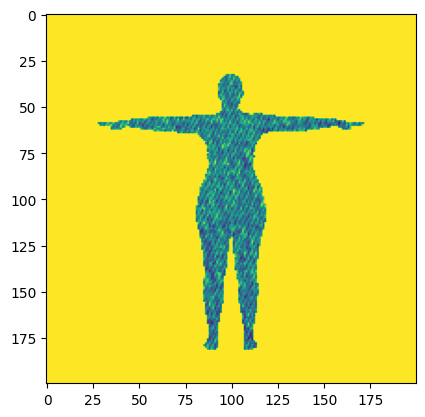

In [99]:
##############################################################
# PREDICTION OF SINGLE EXAMPLES
##############################################################

# folders
# pose 0
#     female  3000
#     male    3000
# pose 1
#     female  3000
#     male    3000

# idx -1 since python starts with 0 idx

image, label = input_dataset[3993]  # male, 0994, pose 0
predict = model.forward(image.unsqueeze(0))

print("-----------------------------------------------")
print("male, 0994, pose 0:")
print("actual:")
print(label)
print("predicted:")
print(predict)
print("-----------------------------------------------")

image, label = input_dataset[2852]  # female, 2853, pose 0
predict = model.forward(image.unsqueeze(0))
plt.imshow(image)

print("-----------------------------------------------")
print("male, 2853, pose 0:")
print("actual:")
print(label)
print("predicted:")
print(predict)
print("-----------------------------------------------")

image, label = input_dataset[10103]  # male, 1104, pose 1
predict = model.forward(image.unsqueeze(0))

print("-----------------------------------------------")
print("male, 1104, pose 1:")
print("actual:")
print(label)
print("predicted:")
print(predict)
print("-----------------------------------------------")

image, label = input_dataset[6411]  # female, 0412, pose 1
predict = model.forward(image.unsqueeze(0))

print("-----------------------------------------------")
print("male, 0412, pose 1:")
print("actual:")
print(label)
print("predicted:")
print(predict)
print("-----------------------------------------------")

In [104]:
import operator

# declare size of the test group
size = 2000
pos = np.random.randint(0, 12000, size)

chest_circumference, height, inseam, left_arm_length, pelvis_circumference, right_arm_length, shoulder_width, waist_circumference = [], [], [], [], [], [], [], []

for el in range(len(pos)):
    image, label = input_dataset[pos[el]]
    predict = model.forward(image.unsqueeze(0))
    result = map(operator.abs,map(operator.sub, label.data.tolist(), predict[0].data.tolist()))

    res = list(result)

    chest_circumference.append(res[0])
    height.append(res[1])
    inseam.append(res[2])
    left_arm_length.append(res[3])
    pelvis_circumference.append(res[4])
    right_arm_length.append(res[5])
    shoulder_width.append(res[6])
    waist_circumference.append(res[7])

    log_enabled = False

    if log_enabled:
        print(res)
        print("-----------------------------------------------")
        print(f"mash: {pos[el]}")
        print("actual:      " + str(label))
        print("predicted:   " + str(predict[0]))

        print("-----------------------------------------------")

[0.04366183280944824, 0.11187374591827393, 0.19929185509681702, 0.09603160619735718, 0.10781311988830566, 0.13676717877388, 0.046082258224487305, 0.24254190921783447]
-----------------------------------------------
mash: 8711
actual:      tensor([1.1996, 1.4833, 0.4071, 0.4640, 1.2787, 0.4728, 0.3795, 1.0351])
predicted:   tensor([1.1559, 1.5952, 0.6063, 0.5601, 1.3865, 0.6095, 0.3334, 1.2777],
       grad_fn=<SelectBackward0>)
-----------------------------------------------


In [102]:
import statistics
print("Median chest circ: " + str(statistics.median(chest_circumference)))
print("Median height: " + str(statistics.median(height)))
print("Median inseam: " + str(statistics.median(inseam)))
print("Median left arm length: " + str(statistics.median(left_arm_length)))
print("Median pelvis circ: " + str(statistics.median(pelvis_circumference)))
print("Median right arm length: " + str(statistics.median(right_arm_length)))
print("Median shoulder width: " + str(statistics.median(shoulder_width)))
print("Median waist circ: " + str(statistics.median(waist_circumference)))

Median chest circ: 0.16585767269134521
Median height: 0.1527298092842102
Median inseam: 0.1396692991256714
Median left arm length: 0.05643349885940552
Median pelvis circ: 0.1652665138244629
Median right arm length: 0.0551353394985199
Median shoulder width: 0.05622546374797821
Median waist circ: 0.27283382415771484
